# Chap3-2: Logistic回归模型

In [8]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

In [9]:
#设定随机种子
torch.manual_seed(2017)

### 导入数据并可视化

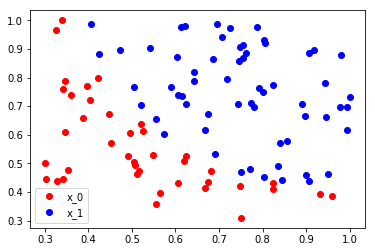

In [10]:
f=open('./data.txt','r')
data_list=[i.split('\n')[0].split(',') for i in f.readlines()]
data = [(float(i[0]), float(i[1]), float(i[2])) for i in data_list]
f.close()
# print(data)
# 标准化
x0_max=max([i[0] for i in data])
x1_max=max([i[1] for i in data])
data=[(i[0]/x0_max, i[1]/x1_max, i[2]) for i in data]
#从list中筛选部分参数的写法!
x0 = list(filter(lambda x:x[-1]==0.0, data)) #第一类点
x1 = list(filter(lambda x:x[-1]==1.0, data)) #第二类点

plot_x0 = [i[0] for i in x0]
plot_y0 = [i[1] for i in x0]
plot_x1 = [i[0] for i in x1]
plot_y1 = [i[1] for i in x1]

plt.plot(plot_x0, plot_y0, 'ro', label='x_0')
plt.plot(plot_x1, plot_y1, 'bo', label='x_1')
plt.legend(loc='best')


### 得到训练数据
接下来我们将数据转换成 NumPy 的类型，接着转换到 Tensor 为之后的训练做准备

In [11]:
np_data = np.array(data, dtype='float32') # 转换成 numpy array
x_data = torch.from_numpy(np_data[:, 0:2]) # 转换成 Tensor, 大小是 [100, 2]
y_data = torch.from_numpy(np_data[:, -1]).unsqueeze(1) # 转换成 Tensor，大小是 [100, 1]

x_data = Variable(x_data)
y_data = Variable(y_data)

### 定义logistic回归模型
在 PyTorch 当中，不需要我们自己写 Sigmoid 的函数，PyTorch 已经用底层的 C++ 语言为我们写好了一些常用的函数，不仅方便我们使用，同时速度上比我们自己实现的更快，稳定性更好

通过导入 `torch.nn.functional` 来使用，下面就是使用方法

In [12]:
import torch.nn.functional as F

# 定义 logistic 回归模型
w = Variable(torch.randn(2, 1), requires_grad=True) #因为输入是2维,所以w的shape是[2,1]
b = Variable(torch.zeros(1), requires_grad=True)

def logistic_regression(x):
    return F.sigmoid(torch.mm(x, w) + b)

### 训练之前的分类效果

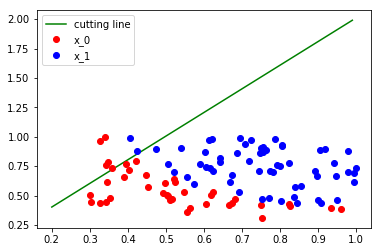

In [26]:
w0 = w[0].data[0]
w1 = w[1].data[0]
b0 = b.data[0]

plot_x = torch.Tensor(np.arange(0.2, 1, 0.01)) #之所以要转换为Tensor, 是因为要参与到下边的共识运算, ndarray不能直接参与运算.
plot_y = (-w0 * plot_x - b0) / w1 #这个公式从何而来?,下边见详解

plt.plot(plot_x.data.numpy(), plot_y.data.numpy(), 'g', label='cutting line')#分割线

plt.plot(plot_x0, plot_y0, 'ro', label='x_0')
plt.plot(plot_x1, plot_y1, 'bo', label='x_1')
plt.legend(loc='best')

#### 扩展: `plot_y = (-w0 * plot_x - b0) / w1`从何而来?
输入有两个维度,即
$$
x=(x_0,x_1)
$$
对应分割线的公式是
$$
w_0*x_0+w_1*x_1+b_0=0
$$
上面的`plot_x`对应着$x_0$,`plot_y`对应$x_1$,所以从以上公式自然有:
$$
x_1=(-w_0*x_0-b_0)/w_1
$$

可以看到分类效果基本是混乱的，我们来计算一下 loss，公式如下

$$
loss = -(y * log(\hat{y}) + (1 - y) * log(1 - \hat{y}))
$$

### 定义损失函数

In [30]:
def binary_loss(y_pred,y_true):
    loss=y_true*y_pred.clamp(1e-12).log()+(1-y_true)*(1-y_pred).clamp(1e-12).log()
    
    return -loss.mean()
#log函数不能接受负值, 所以我们此处加上了tensor.clamp(1e-12),保证是个正数. tensor.clamp(min,max)是保证tensor的数值在区间之内

#### 扩展: `tensor.clamp(min,max)`, `tensor.clamp_(min,max)`
clamp: v. 夹紧，固定住；用夹锁锁住（车）；保持（电信号）电压极限在规定水平

In [28]:
tensor=torch.randn(2,3)
print('原始tensor:\n{}'.format(tensor))
tensor2=tensor.clamp(-0.5,0.5)
tensor.clamp_(-0.5,0.5)
print('框定区间后:\n{}'.format(tensor))
print('框定区间后:\n{}'.format(tensor2))

原始tensor:
tensor([[-1.0780,  1.7048,  0.1365],
        [ 0.7977,  0.7078,  0.4767]])
框定区间后:
tensor([[-0.5000,  0.5000,  0.1365],
        [ 0.5000,  0.5000,  0.4767]])
框定区间后:
tensor([[-0.5000,  0.5000,  0.1365],
        [ 0.5000,  0.5000,  0.4767]])


### 得到损失

In [31]:
y_pred=logistic_regression(x_data)
loss=binary_loss(y_pred, y_data)
print(loss)

tensor(0.6412, grad_fn=<NegBackward>)


C:\APP\Anaconda\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


### 更新一次参数

In [32]:
loss.backward()
w.data=w.data-0.1*w.grad.data
b.data=b.data-0.1*b.grad.data

# 算出一次更新之后的loss
y_pred= logistic_regression(x_data)
loss= binary_loss(y_pred, y_data)
print(loss)

tensor(0.6407, grad_fn=<NegBackward>)


C:\APP\Anaconda\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


### Pytorch自带的优化更新函数-- torch.optim

上面的参数更新方式其实是繁琐的重复操作，如果我们的参数很多，比如有 100 个，那么我们需要写 100 行来更新参数，为了方便，我们可以写成一个函数来更新，其实 PyTorch 已经为我们封装了一个函数来做这件事，这就是 PyTorch 中的优化器 `torch.optim`

使用 `torch.optim` 需要另外一个数据类型，就是 `nn.Parameter`，这个本质上和 `Variable` 是一样的，只不过 `nn.Parameter` 默认是要求梯度的，而 `Variable` 默认是不求梯度的

使用 `torch.optim.SGD` 可以使用梯度下降法来更新参数，PyTorch 中的优化器有更多的优化算法，在本章后面的课程我们会更加详细的介绍.

将参数`w`和`b`放到`torch.optim.SGD`中之后,说明一下学习率的大小,就可以使用`optimizer.step()`来更新参数了,比如下面我们将参数传入优化器,学习率设置为`1.0`

### 1. 使用torch.optim更新参数

In [95]:
from torch import nn
w=nn.Parameter(torch.randn(2,1))
b=nn.Parameter(torch.zeros(1))
def logistic_regression(x):
    return F.sigmoid(torch.mm(x,w)+b)
optimizer=torch.optim.SGD([w,b],lr=1)

### 2.使用torch.optim进行1000次更新, 注意在更新参数之前要将梯度归零.

In [96]:
import time
start=time.time()
for e in range(1000):
    y_pred=logistic_regression(x_data)#y_pred=[100,1],是100个样本是正例的概率
    loss=binary_loss(y_pred,y_data)
    #反向传播
    optimizer.zero_grad() #使用优化器将梯度归0
    loss.backward()
    optimizer.step() #使用优化器来更新参数,这一步便是核心更新公式.
    
    #计算正确率,mask代表模型真正的输出,1代表正例,0代表负例.
    mask=y_pred.ge(0.5).float()#因为是long类型,转换为float类型
    acc=(mask==y_data).sum().numpy()/y_data.shape[0]
    if e%200==0:
        print('epoch:{},Loss:{:.5f},Acc:{:.5f}'.format(e,loss.data[0],acc))
during=time.time() -start
print('During Time: {:.3f} s'.format(during))

C:\APP\Anaconda\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\APP\Anaconda\lib\site-packages\ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


epoch:0,Loss:0.65544,Acc:0.63000
epoch:200,Loss:0.39688,Acc:0.91000
epoch:400,Loss:0.32460,Acc:0.92000
epoch:600,Loss:0.29067,Acc:0.91000
epoch:800,Loss:0.27079,Acc:0.91000
During Time: 0.310 s


#### 扩展一: tensor.ge() 阈值函数
通过设置一个阈值, 大于此值的元素设为1, 小于此值设为0

In [57]:
a=torch.randn(2,3)
print(a)
print(a.ge(0.5))

tensor([[ 1.3656, -0.0504, -1.8136],
        [-0.2775,  0.4706, -0.0737]])
tensor([[1, 0, 0],
        [0, 0, 0]], dtype=torch.uint8)


#### 扩展二: acc的计算过程, tensor1==tensor2对应元素比较大小
`acc=(mask==y_data).sum().numpy()/y_data.shape[0]`

In [68]:
a=torch.Tensor([1,2,3,4,5])
b=torch.Tensor([1,3,2,4,5])
right_tensor=(a==b)
print(right_tensor)
right_num=right_tensor.sum()
print('判断正确的数量:{}'.format(right_num))
all_num=a.shape[0]
print('所有样本的数量:{}'.format(all_num))
acc=right_num.numpy()/all_num
print('准确率:{}'.format(acc))

tensor([1, 0, 0, 1, 1], dtype=torch.uint8)
判断正确的数量:3
所有样本的数量:5
准确率:0.6


#### 扩展三: format中保留指定位数的小数:

In [76]:
a=3.1415926
print('保留2位小数后:{:.2f}'.format(a))
print('保留3位小数后:{:.3f}'.format(a))

保留2位小数后:3.14
保留3位小数后:3.142


### 3.画出更新之后的结果

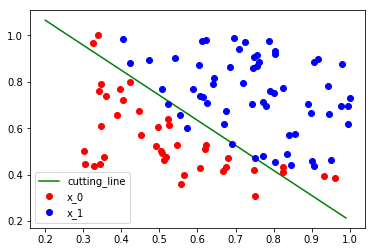

In [97]:
w0=w[0].data[0] #w0即便是都.data[0],类型依旧是tensor
w1=w[1].data[0]
b0=b.data[0]

plot_x=torch.Tensor(np.arange(0.2,1,0.01))
plot_y=(-w0*plot_x-b0)/w1

plt.plot(plot_x.data.numpy(),plot_y.data.numpy(),'g',label='cutting_line')

plt.plot(plot_x0,plot_y0,'ro',label='x_0')
plt.plot(plot_x1,plot_y1,'bo',label='x_1')

plt.legend()

### Pytorch自带的loss函数--`nn.MSE()`,`nn.BCEWithLogitsLoss()`

前面我们使用了自己写的 loss，其实 PyTorch 已经为我们写好了一些常见的 loss，比如线性回归里面的 loss 是 nn.MSE()，而 Logistic 回归的二分类 loss 在 PyTorch 中是 nn.BCEWithLogitsLoss()，关于更多的 loss，可以查看文档

PyTorch 为我们实现的 loss 函数有两个好处，第一是方便我们使用，不需要重复造轮子，第二就是其实现是在底层 C++ 语言上的，所以速度上和稳定性上都要比我们自己实现的要好

另外，PyTorch 出于稳定性考虑，将模型的 Sigmoid 操作和最后的 loss 都合在了 nn.BCEWithLogitsLoss()，所以我们使用 PyTorch 自带的 loss 就不需要再加上 Sigmoid 操作了

In [103]:
criterion=nn.BCEWithLogitsLoss() #criterion denotes 标准
w=nn.Parameter(torch.randn(2,1))
b=nn.Parameter(torch.zeros(1))

def logistic_reg(x): #reg denotes regression
    return torch.mm(x,w)+b #
optimizer=torch.optim.SGD([w,b],lr=1.0)

y_pred=logistic_reg(x_data)
loss=nn.BCEWithLogitsLoss()(y_pred, y_data)
print(loss)

tensor(0.6649, grad_fn=<MeanBackward1>)


#### 1.使用自带的loss进行1000次更新

In [104]:
start=time.time()
for e in range(1000):
    #前向传播
    y_pred=logistic_reg(x_data)
    loss=criterion(y_pred,y_data)
    #反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #计算正确率
    mask=y_pred.ge(0.5).float()
    acc=(mask==y_data).sum().numpy()/y_data.shape[0]
    if (e+1)%200==0:
        print('epoch:{},loss:{:.5f},acc:{:.5f}'.format(e,loss,acc))
during=time.time()-start

print(during)

epoch:199,loss:0.38986,acc:0.88000
epoch:399,loss:0.32178,acc:0.87000
epoch:599,loss:0.28913,acc:0.87000
epoch:799,loss:0.26981,acc:0.87000
epoch:999,loss:0.25698,acc:0.88000
0.2533223628997803


可以看到，使用了 PyTorch 自带的 loss 之后，速度有了一定的上升，虽然看上去速度的提升并不多，但是这只是一个小网络，对于大网络，使用自带的 loss 不管对于稳定性还是速度而言，都有质的飞跃，同时也避免了重复造轮子的困扰

## 总结
- `list(filter(lambda func, data))`:python从list中筛选某些值
- `tensor.clamp(min,max)`,`tensor.clamp_(min,max)`:顾名思义,从tensor中clamp出设定区间的元素.
- `torch.optim.SGD`:pytorch自带优化更新函数:
 1. 定义优化器: `optimizer=torch.optim.SGD([Parameter],lr=)`
 2. 归零梯度:`optimizer.zero_grad()`
 3. 定义损失求导:`loss.backward()`
 4. 优化更新:`optimizer.step()`
- `tensor.ge(number)`:判断是否大于阈值,大于为1,小于为0.常用于计算acc
- `tensor==tensor`:对应元素比较是否相等,相等为1,不相等为0.常用于计算acc
- `nn.BCEWithLogitsLoss()(y_pred,y_true)`:逻辑回归二分类损失,自带sigmoid函数,`y_pred`只需要是`torch.mm(x,w)+b`之后就可以,不需要`F.sigmoid()`